CPU times: user 376 ms, sys: 120 ms, total: 496 ms
Wall time: 493 ms
CPU times: user 40 ms, sys: 4 ms, total: 44 ms
Wall time: 39.6 ms


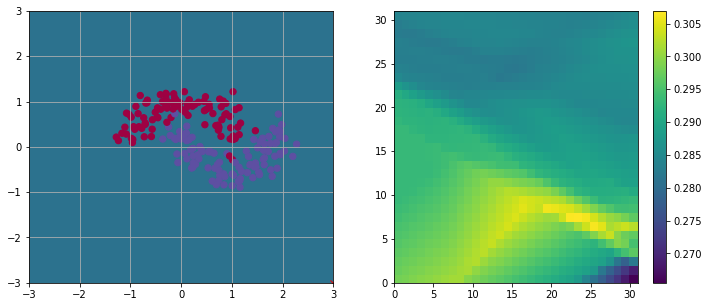

In [17]:
# from surfer import *
from pymisca.optim import *
from pymisca.util import *

import sklearn.datasets
import sklearn.linear_model

# from surfer import *

np.random.seed(3) 
X, y = sklearn.datasets.make_moons(200, noise=0.20) 
# with open('tofit.npy','w') as f:

data = {'input':X,'output':y}
np.save('tofit.npy',data,)
def data_scatter(X):
    plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
    
def view_model(m,axs = None,obs=None,**kwargs):
    if axs is None:
        fig,axs =plt.subplots(1,2,figsize = [12,5])
    plt.sca(axs[0])
    zs,xs,ys = dmet_2d( f_2d(m.predict,transpose=1),span=[-3,3],levels=np.linspace(0,1,5),**kwargs);
    data_scatter(obs['input'])
    plt.sca(axs[1])
    plt.pcolormesh(zs)
    plt.colorbar()

    return axs
    

# %% 3 
# Train the logistic rgeression classifier 
clf = sklearn.linear_model.LogisticRegressionCV() 
clf.fit(X, y) 

# view_model(clf,obs=data)
# plt.show()
obs = [X,y]


from util_nn import *


import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import keras
import keras.layers as KL
import keras.optimizers as KO

# m = keras.models.Sequential()
x = KL.Input(shape=(2,))
input_layer = x
# x = KL.Dense(4)(x)
# x = KL.Activation('relu',name = 'hidden-activation',)(x)
nH = 5
for i in range(nH):
    x = KL.Dense(6)(x)
    x = KL.Activation('relu',)(x)
#     x = KL.Activation('sigmoid',)(x)

x = KL.Dense(1)(x)
x = KL.Activation('sigmoid',name = 'sigmoid')(x)
output_layer = x
m = keras.models.Model(input_layer,output_layer)
# m.summary()
# optim = keras.optimizers.sgd()
optim = keras.optimizers.adagrad()
m.compile(loss=keras.losses.binary_crossentropy, optimizer=optim
#           ,metrics=['loss']
         )
m1 = m
# hist = m1.fit(*obs,batch_size=len(X), nb_epoch = 10)
hist = m1.fit(obs[0],obs[1],batch_size=len(obs[0]), epochs = 50,verbose=0)
# hist = m1.fit(obs[0],obs[1], epochs = 10)
# axs = view_model(m,obs=data)
# plt.show()

fname = 'totest.hdf5'
# m1.save(fname)
m.save(fname)
# fname = 'totest.hdf5'
# m1.save(fname)

# normalization
# l2_norm = lambda x: np.mean(np.square(x),axis=-1)


##### Wrap the network weights
W = m.get_weights()
SHAPE = [(e.size,e.shape) for e in W]
SHAPE = zip(*SHAPE)
m.gradF = make_gradient_function(m)
idx = np.cumsum(SHAPE[0])
D = idx[-1]
SHAPE_idx = idx[:-1]
# def 

def weight2flat(W):
    flat = np.hstack([np.ravel(x) for x in W])
    return flat
flat2weight = lambda flat:[np.reshape( x, SHAPE[1][i] ) for i,x in enumerate(np.split(flat,SHAPE_idx))]
# const = 0.01
# const = 1
# const = 0.  ### log(1)
const = .1
def flat2loss(*flat):
    Wout = flat2weight(flat)
#     Wout = [np.reshape( x, SHAPE[1][i] ) for i,x in enumerate(np.split(flat,idx))]
    m.set_weights(Wout)
    loss = m.evaluate(data['input'],data['output'],verbose=0)
    ## L2 norm
    loss += const * np.mean(np.square(flat))
#     loss += np.square(np.log(l2_norm(flat)) - const)
    return loss
def gradF(*flat):
    Wout = flat2weight(flat)
#     Wout = [np.reshape( x, SHAPE[1][i] ) for i,x in enumerate(np.split(flat,idx))]
    m.set_weights(Wout)
    grad = get_gradients(data,gradF=m.gradF)
    grad = weight2flat(grad)
#     print Wout.shape
#     grad = np.add(grad, np.multiply(2 *const, flat)/len(flat))

    dgrad = np.multiply(2 *const, flat)/len(flat)
#     norm = l2_norm(flat)
#     dgrad = 4*(np.log(norm)-const) / norm /len(flat) * np.array(flat)
    grad = np.add(grad, dgrad)
    return grad

h = flat2loss

np.random.seed(0)
reset_weights(m)
x = (np.random.random(weight2flat(W).shape) - 0.5 )*2
# x = weight2flat(m.get_weights())
v = (np.random.random(x.shape) - 0.5 )*0.1
x0 = np.hstack([x,v])

h = flat2loss
g = make_gradF(h)
%time h(*x0[:D])
%time gradF(*x0[:D])

view_model(m,obs=data)
x = x0
plt.show()
# %time g(*x0[:D])
# flat2loss()
# flat2loss
# np.reshape(s,shape)
x = weight2flat(m.get_weights())
x0 = np.hstack([x,x]).copy()

Initial coordinate: [ 3.78628583 -4.08702644  1.54678127 -1.2187889  -5.24744458 -0.91161298]
Initial  objective: 9.27035572779517
Ending  coordinate: [ 0.00594735 -0.0091459   0.00138851  0.0026444  -0.00593561 -0.00434184]
Ending  objective: 0.6937923070548072
[WARN] cannot plot coutour cannot reshape array of size 2 into shape (2,6)


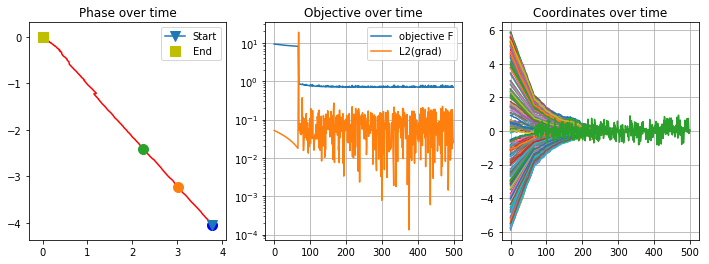

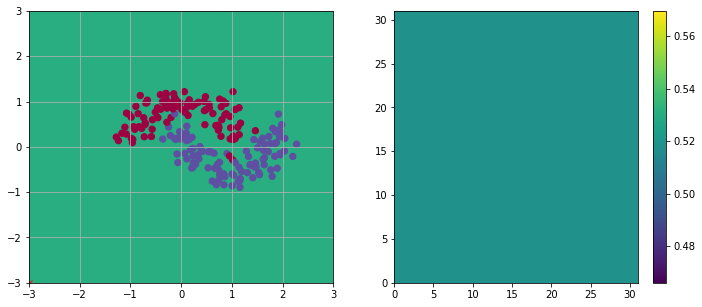

In [18]:
### An unsual case where the model collapsed itself under L2 reg

### Without momentum
# for i in range(5):
if 1:
    out = main(flat2loss,gradF =gradF,D = D,nStep=500,alpha=None)
#     out = main(flat2loss,gradF =gradF,D = D,nStep=500,alpha=None,eta=0.05)
    view_model(m,obs=data)
    plt.show()

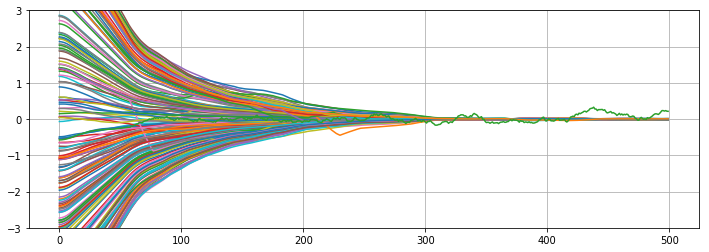

In [ ]:
import scipy.ndimage as spimg
n = 20

X = out['coord']
X = np.array(X)
# X = np.convolve
rd = 3.0
plt.figure(figsize=[12,4])
Y = spimg.convolve(X,[[1./n]]*n)
plt.plot(Y[:,:D])
plt.grid()
plt.ylim(-rd,rd)
plt.show()

In [ ]:
### Without momentum
# for i in range(5):
if 1:
    out = main(flat2loss,gradF =gradF,D = D,nStep=2500,alpha=None,eta=0.5)
    view_model(m,obs=data)
    plt.show()

Initial coordinate: [-3.71376964 -0.99597271 -2.68487084 -3.62333645 -1.62525534 -2.45092578]
Initial  objective: 12.652941100474717


In [ ]:
import scipy.ndimage as spimg
n = 20

X = out['coord']
X = np.array(X)
# X = np.convolve
rd = 3.0
plt.figure(figsize=[12,4])
Y = spimg.convolve(X,[[1./n]]*n)
plt.plot(Y[:,:D])
plt.grid()
plt.ylim(-rd,rd)
plt.show()

In [ ]:
### Without momentum
# for i in range(5):
if 1:
    out = main(flat2loss,gradF =gradF,D = D,nStep=2500,x0=rand_point(D=D,rd=0.5),alpha=0.02)
    view_model(m,obs=data)
    plt.show()

In [ ]:
import scipy.ndimage as spimg
n = 50

X = out['coord']
X = np.array(X)
# X = np.convolve
rd = 1.0
plt.figure(figsize=[12,4])
Y = spimg.convolve(X,[[1./n]]*n)
plt.plot(Y[:,:D])
plt.grid()
plt.ylim(-rd,rd)
plt.show()
plt.hist(np.abs(Y[-1]),log=1)
plt.show()

In [ ]:
out = main(flat2loss,gradF =gradF,D = D,nStep=2500,alpha=0.8)
view_model(m,obs=data)
plt.show()

In [ ]:
import scipy.ndimage as spimg
n = 50

X = out['coord']
X = np.array(X)
# X = np.convolve
rd = 5.0
plt.figure(figsize=[12,4])
Y = spimg.convolve(X,[[1./n]]*n)
plt.plot(Y[:,:D])
plt.grid()
plt.ylim(-rd,rd)
plt.show()
plt.hist(np.abs(Y[-1]),log=1)
plt.show()